# XAI SHAP applied to XGBRegressor

Load trained XGBRegressor

In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split

from faa_p2.config import CLEAN_DATA_FILE, MODELS, RANDOM_STATE, DATA_SPLIT_RATIO, XGBR

In [ ]:
# load data + model
df = pd.read_csv(CLEAN_DATA_FILE, index_col=0)
y = df["medv"]
X = df.drop(columns=["medv"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=DATA_SPLIT_RATIO, random_state=RANDOM_STATE
)

model = joblib.load(MODELS[XGBR]["filename"])

In [ ]:
shap.initjs()

# for tree-based models TreeExplainer is the right one
explainer = shap.TreeExplainer(model)

X_test_small = X_test.copy()
shap_values = explainer.shap_values(X_test_small)

print("SHAP values shape:", np.array(shap_values).shape)

SHAP values shape: (102, 13)


#### Global Feature Importance (beeswarm plot)

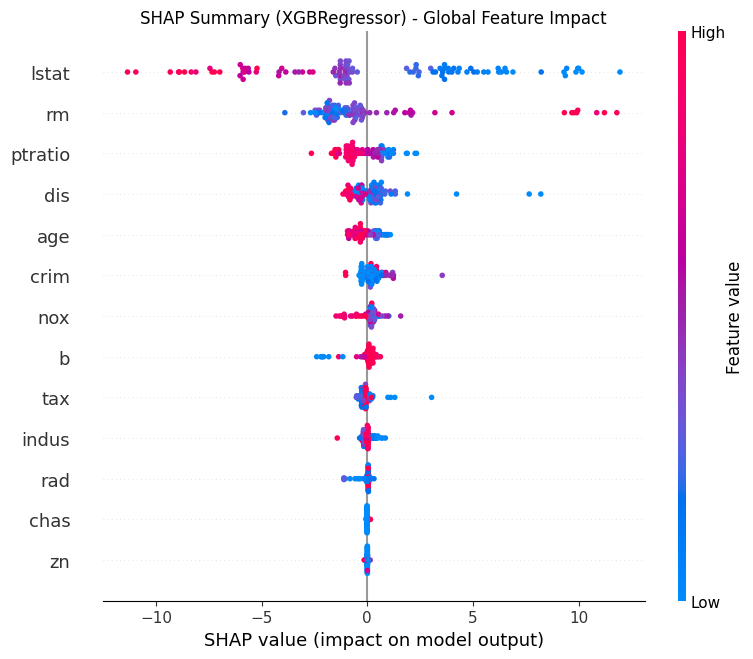

In [15]:
# 1) global importance (beeswarm)
shap.summary_plot(shap_values, X_test_small, show=False)
plt.title("SHAP Summary (XGBRegressor) - Global Feature Impact")
plt.tight_layout()
plt.show()

### Global view (Summary / Beeswarm)
- Each dot is one house from the test set.
- The **x-axis (SHAP value)** shows how much a feature **pushes the prediction up or down** compared to the model’s average prediction.
  - **Positive** SHAP value → increases predicted price  
  - **Negative** SHAP value → decreases predicted price
- The **color** shows the feature value:
  - **Red = high feature value**, **Blue = low feature value**
- Main takeaways:
  - **`lstat`** is the strongest driver: **higher `lstat` values mostly push prices down**, while low `lstat` pushes prices up.
  - **`rm`** is also very influential: **more rooms generally pushes prices up**, fewer rooms pushes them down.
  - **`ptratio`** tends to have a negative effect: **higher pupil-teacher ratio usually lowers predicted price**.
  - Features like `dis`, `age`, `crim`, `nox` matter, but typically less than `lstat` and `rm`.
  - `chas` and `zn` contribute very little overall in this model.

### Global Feature Importance (bar plot)

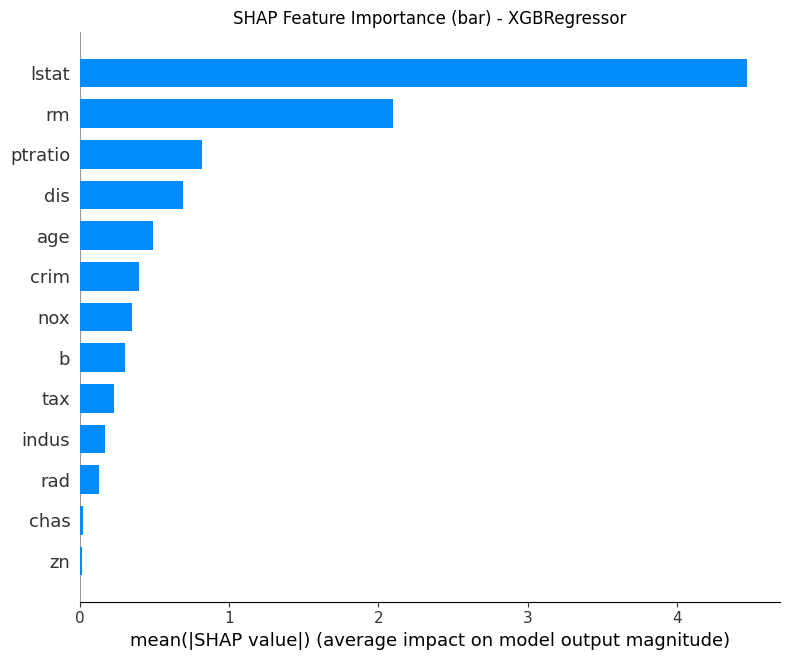

In [16]:
# 2) global importance (bar)
shap.summary_plot(shap_values, X_test_small, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (bar) - XGBRegressor")
plt.tight_layout()
plt.show()

### Global ranking (Bar plot)
- This plot ranks features by their **average impact size** (ignores direction).
- It confirms the same ordering: **`lstat` > `rm` > `ptratio`**, followed by `dis`, `age`, `crim`, `nox`, etc.

### Dependence plot for top rated features

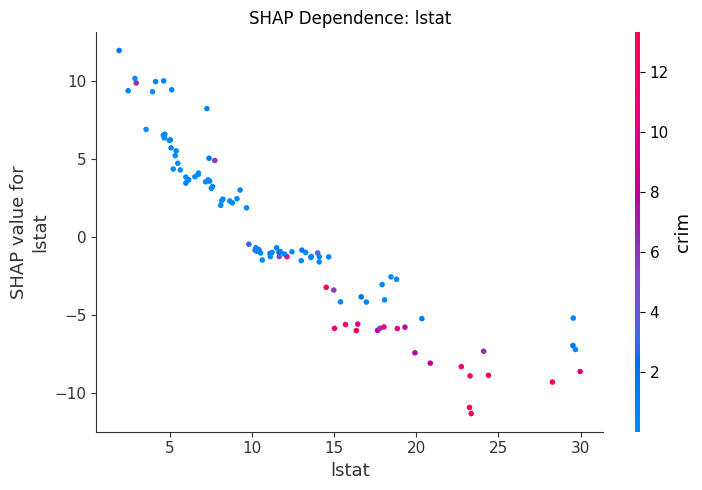

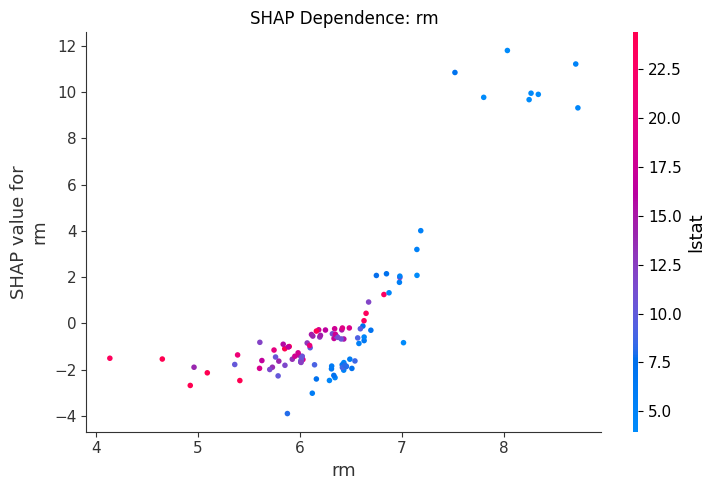

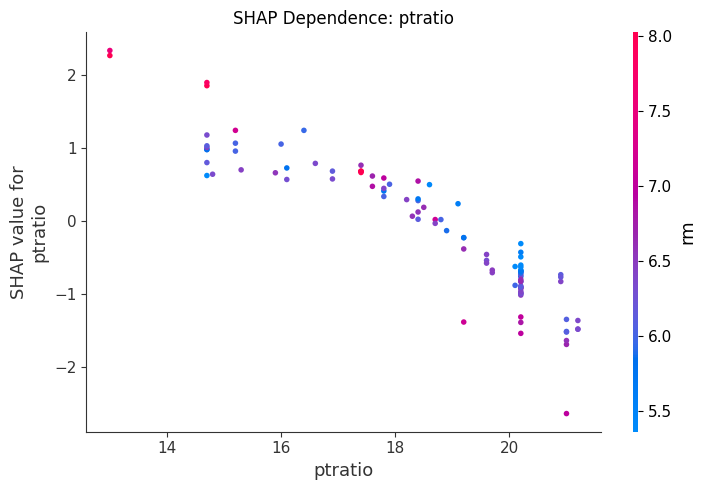

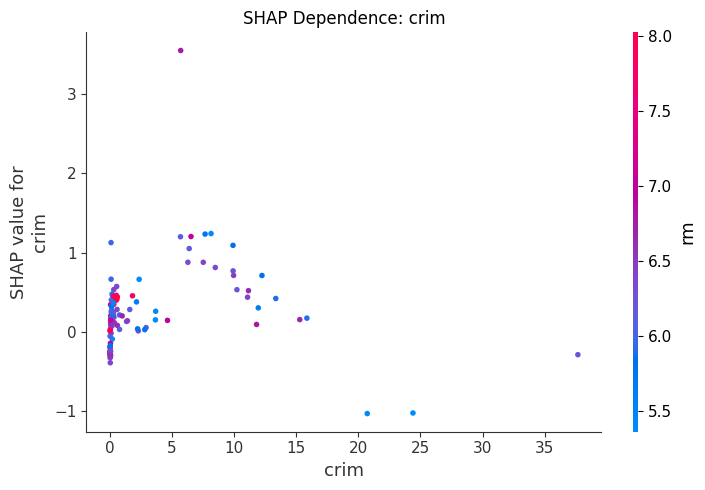

In [21]:
# 3) dependence plot for top features
for feat in ["lstat", "rm", "ptratio", "crim"]:
    if feat in X_test_small.columns:
        shap.dependence_plot(feat, shap_values, X_test_small, show=False)
        plt.title(f"SHAP Dependence: {feat}")
        plt.tight_layout()
        plt.show()

### Dependence plots (feature effect shapes)
- These plots show how a feature’s value relates to its SHAP contribution.
- They highlight **non-linear patterns** and possible interactions (shown by the color).
- Examples from the plots:
  - **`lstat`** shows a clear downward trend: higher values strongly reduce the predicted price.
  - **`rm`** shows higher values increasing predicted price, with the effect becoming stronger for high room counts.
  - **`ptratio`** shows higher values generally decreasing predicted price.
  - **`crim`** has more scattered effects, consistent with a skewed/outlier-heavy feature.

### Local explanation for one example

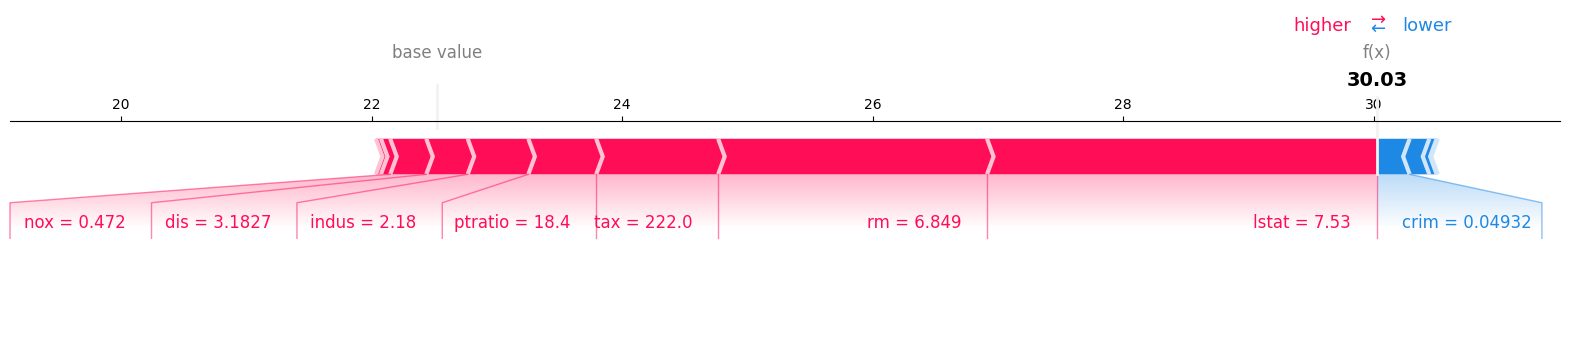

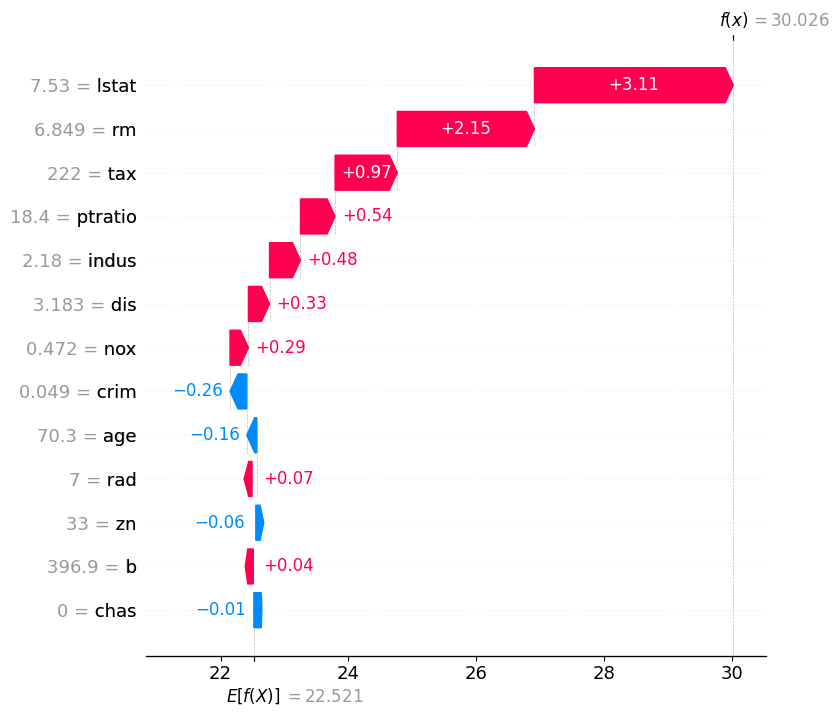

In [18]:
# 4) local explanation for one example
i = 0  # change index to inspect another test point
x_row = X_test_small.iloc[i]

# force plot
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    x_row,
    matplotlib=True,
)
plt.show()

# waterfall plot (static)
sv = shap.Explanation(
    values=shap_values[i],
    base_values=explainer.expected_value,
    data=x_row.values,
    feature_names=X_test_small.columns,
)
shap.plots.waterfall(sv, max_display=14)

### Local explanation (Force plot)

- This explains **one single prediction** (the test example at index `i`).
- It starts from the model’s **baseline** (the average prediction for the dataset), shown as **“base value”**.
- Then each feature **pushes the prediction** either:
  - **to the right (red)** → makes the predicted price **higher**
  - **to the left (blue)** → makes the predicted price **lower**
- Adding all pushes to the baseline gives the final prediction **f(x)** (shown on the top right).  
  As seen above the prediction is **≈ 30.03**.

#### Specific details of this example
- The **red features** are the main reasons this house is predicted **above average**:
  - **`rm = 6.849`** (more rooms) pushes the prediction up a lot.
  - **`lstat = 7.53`** (lower `lstat`) also pushes the prediction up.
  - `tax`, `ptratio`, `indus`, `dis`, `nox` add smaller positive pushes (in this case).
- The **blue feature(s)** are pulling the prediction down:
  - **`crim = 0.04932`** has a small negative effect here (blue), slightly reducing the prediction.

### Local explanation (Waterfall plot)
- This explains a **single prediction**:
  - Starts at the model baseline (**average prediction**).
  - Adds each feature’s **SHAP contribution** (red increases, blue decreases) to reach the final prediction **f(x)**.
- It shows which specific features were the main reasons the model predicted a higher or lower house price for that one example.
- This plot is similar to the force plot but shows the same information in a more detailed, ordered way.